## Step A.	Building Count for each 500m grid 

(matching extent of my TIFF file with that of Madhvi's)

In [154]:
def step_A(shapefile_path, reference_raster_path, new_raster_path):
    import geopandas as gpd
    import rasterio
    import numpy as np

    # Step 0: Read the existing raster for bounds and transforms
    with rasterio.open(reference_raster_path) as existing_raster:
        transform = existing_raster.transform
        bounds = existing_raster.bounds
        cell_size = existing_raster.res[0]
        width = existing_raster.width
        height = existing_raster.height
        crs = existing_raster.crs

    # Step 1: Read the shapefile
    points = gpd.read_file(shapefile_path)

    # Step 2: Create the raster with the same extent as the existing raster
    with rasterio.open(new_raster_path, 'w', driver='GTiff', height=height,width=width,
                       count=1, dtype=rasterio.uint32, crs=crs, transform=transform,
                       nodata=9999) as dst:
        # Step 3: Count points in each cell
        counts = np.zeros((height, width), dtype=np.uint32)
        for point in points.geometry:
            row, col = dst.index(point.x, point.y)
            if bounds.left <= point.x <= bounds.right and bounds.bottom <= point.y <= bounds.top:
                if 0 <= row < height and 0 <= col < width:
                    counts[row, col] += 1
        # Step 4: Update raster values
        counts[counts == 0] = 9999
        dst.write(counts, 1)

In [69]:
shapefile_path = 'MapPluto_small_boundary_WGS_Mercator_points.shp'
reference_raster_path = 'A_Building_Count.tif'
new_raster_path = 'A_Building_Count_Same_Extent.tif'
step_A(shapefile_path, reference_raster_path, new_raster_path)

Extra function to show the radef raster_as_numpy_array(tif_file_path):
    
    import rasterio
    import numpy as np

    # Open the TIFF file
    with rasterio.open(tif_file_path) as src:
        # Read the raster data
        raster_data = src.read()
        numpy_array = np.array(raster_data)
    print(numpy_array)ster as numpy array

In [155]:
def raster_as_numpy_array(tif_file_path):
    
    import rasterio
    import numpy as np

    # Open the TIFF file
    with rasterio.open(tif_file_path) as src:
        # Read the raster data
        raster_data = src.read()
        numpy_array = np.array(raster_data)
    print(numpy_array)

#### Visualize raster

In [156]:
#  A function  o visualize a raster file

def visualize_raster(tif_file_path, missing_value=None):
    import rasterio
    import numpy as np
    import matplotlib.pyplot as plt

    # Open the TIFF file
    with rasterio.open(tif_file_path) as src:
        # Read the raster data
        raster_data = src.read()

        #  Covert the raster data to nmppyy array
        numpy_array = np.array(raster_data)

    single_band_data = numpy_array[0] if numpy_array.ndim == 3 else numpy_array
    
    # Mask the missing values if a missing value is specified
    if missing_value is not None:
        if missing_value > 0:
            masked_data = np.ma.masked_where(single_band_data == missing_value, single_band_data)
        else:
            masked_data = np.ma.masked_where(single_band_data <= missing_value, single_band_data)
    else:
        masked_data = single_band_data

    plt.imshow(masked_data, cmap='gray')
    plt.colorbar()
    plt.title('Single-band raster data')
    plt.show()

Now plot it.

In [72]:
raster_as_numpy_array('A_Building_Count_Same_Extent.tif')

[[[9999 9999 9999 9999    1    5   37   26   39 9999]
  [9999 9999 9999 9999 9999    4    4   36   47 9999]
  [9999 9999 9999 9999    2    5    2    3    8 9999]
  [9999 9999 9999    2    3    4    2    3   11 9999]
  [9999 9999 9999    4   10    9    6    2    6 9999]
  [   1    2 9999    4    3    4    1    1    1 9999]
  [9999    2 9999    3    4    6    6    2    4 9999]
  [   1    1    5    6    4    5    4    3   10 9999]
  [   2    1    3    4    6   34   18    6    4 9999]
  [   1   13    7    5   11   21   32    8    9    1]
  [   1    9   10    8   12   26   18   26   17 9999]
  [   2    7   26    8   28   20   22   10   12 9999]]]


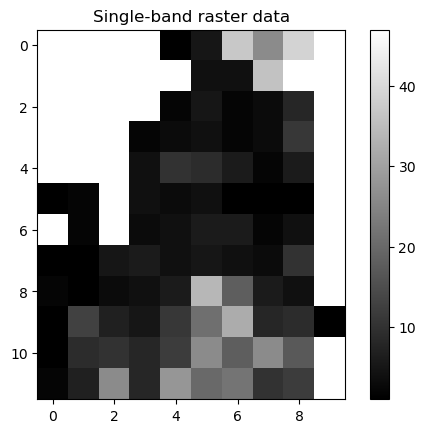

In [73]:
visualize_raster('A_Building_Count_Same_Extent.tif', missing_value=9999)

Now compare it with output from ArcGIS (by Madhvi)

In [74]:
raster_as_numpy_array('A_Building_Count.tif')

[[[2147483647 2147483647 2147483647 2147483647          1          5
           37         26         39 2147483647]
  [2147483647 2147483647 2147483647 2147483647 2147483647          4
            4         36         47 2147483647]
  [2147483647 2147483647 2147483647 2147483647          2          5
            2          3          8 2147483647]
  [2147483647 2147483647 2147483647          2          3          4
            2          3         11 2147483647]
  [2147483647 2147483647 2147483647          4         10          9
            6          2          6 2147483647]
  [         1          2 2147483647          4          3          4
            1          1          1 2147483647]
  [2147483647          2 2147483647          3          4          6
            6          2          4 2147483647]
  [         1          1          5          6          4          5
            4          3         10 2147483647]
  [         2          1          3          4          6       

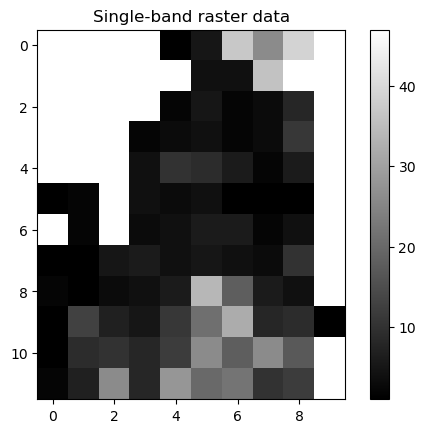

In [75]:
visualize_raster('A_Building_Count.tif', missing_value=2147483647)

They look the same. The only differece is that for NoData Value, I have used 9999 and Madhvi used 2147483647. 

## Step B. Build_Hgts_sum for each 500m grid

Write a general function for summing up by a vector field.

In [157]:
def raster_sum(shapefile_path, reference_raster_path, new_raser_path, field_name):
    import geopandas as gpd
    import rasterio
    import numpy as np
    
    # Step 0: Read the existing raster for bounds and transforms
    with rasterio.open(reference_raster_path) as existing_raster:
        transform = existing_raster.transform
        bounds = existing_raster.bounds
        cell_size = existing_raster.res[0]
        width = existing_raster.width
        height = existing_raster.height
        crs = existing_raster.crs
        
    # Step 1: Read the shapefile
    points = gpd.read_file(shapefile_path)
    
    # Step 2: Create the raster with the same extent as the existing raster
    with rasterio.open(new_raster_path, 'w', driver='GTiff', height=height, width=width,
                      count=1, dtype=rasterio.float32, crs=crs, transform=transform,
                      nodata=9999.0) as dst:
        sums = np.full((height, width), 9999.0, dtype=np.float32) # Initialize with NoData value
        for point, value in zip(points.geometry, points[field_name]):
            row, col = dst.index(point.x, point.y)
            if bounds.left <= point.x <= bounds.right and bounds.bottom <= point.y <= bounds.top:
                if 0 <= row < height and 0 <= col < width:
                    if sums[row, col] == 9999.0: # If currently NoData, make it 0 before summing
                        sums[row, col] = 0.0
                    sums[row, col] += value
                        
        # Step 4: Write this sum to a raster file
        dst.write(sums, 1)

In [88]:
def step_B(shapefile_path, reference_raster_path, new_raster_path):
    raster_sum(shapefile_path, reference_raster_path, new_raster_path, 'Build_Hgt')

In [89]:
shapefile_path = 'MapPluto_small_boundary_WGS_Mercator_points.shp'
reference_raster_path = 'A_Building_Count.tif'
new_raster_path = 'B_Building_Heights_Sum_Same_Extent.tif'
step_B(shapefile_path, reference_raster_path, new_raster_path)

In [90]:
raster_as_numpy_array('B_Building_Heights_Sum_Same_Extent.tif')

[[[9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   0.00000000e+00 0.00000000e+00 8.30800049e+02 7.88924988e+02
   7.87250000e+02 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   9.99900000e+03 2.88100006e+02 2.54600006e+02 6.63299927e+02
   9.94950073e+02 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   0.00000000e+00 2.64650024e+02 1.90949997e+02 2.04350006e+02
   5.52750000e+02 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 0.00000000e+00
   1.00500000e+02 1.94300003e+02 9.71500015e+01 2.41199997e+02
   5.79549988e+02 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 1.10550003e+02
   5.09199982e+02 1.80899994e+02 1.94299988e+02 1.67500000e+02
   3.18250000e+02 9.99900000e+03]
  [0.00000000e+00 6.69999981e+00 9.99900000e+03 3.68500000e+02
   2.27800003e+02 8.04000015e+01 4.35499992e+01 1.33999996e+01
   1.67500000e+01 9.99900000e+03]
  [9.99900000e+03 0.00000000e+00 9.99900

Now plot it.

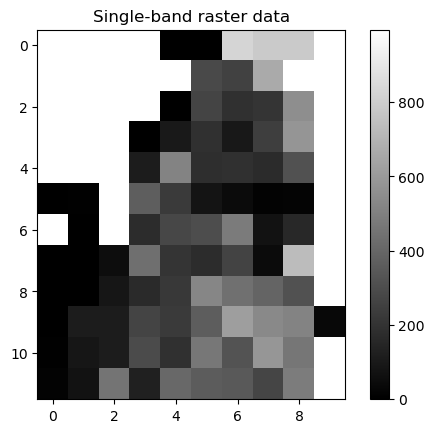

In [91]:
visualize_raster('B_Building_Heights_Sum_Same_Extent.tif', missing_value=9.99900000e+03)

Now compare it with output from ArcGIS (by Madhvi)

In [93]:
raster_as_numpy_array('B_Building_Heights_Sum.tif')

[[[-3.40282347e+38 -3.40282347e+38 -3.40282347e+38 -3.40282347e+38
    0.00000000e+00  0.00000000e+00  8.30799988e+02  7.88924988e+02
    7.87250000e+02 -3.40282347e+38]
  [-3.40282347e+38 -3.40282347e+38 -3.40282347e+38 -3.40282347e+38
   -3.40282347e+38  2.88100006e+02  2.54600006e+02  6.63299988e+02
    9.94950012e+02 -3.40282347e+38]
  [-3.40282347e+38 -3.40282347e+38 -3.40282347e+38 -3.40282347e+38
    0.00000000e+00  2.64649994e+02  1.90950012e+02  2.04350006e+02
    5.52750000e+02 -3.40282347e+38]
  [-3.40282347e+38 -3.40282347e+38 -3.40282347e+38  0.00000000e+00
    1.00500000e+02  1.94300003e+02  9.71500015e+01  2.41199997e+02
    5.79549988e+02 -3.40282347e+38]
  [-3.40282347e+38 -3.40282347e+38 -3.40282347e+38  1.10550003e+02
    5.09200012e+02  1.80899994e+02  1.94299988e+02  1.67500000e+02
    3.18250000e+02 -3.40282347e+38]
  [ 0.00000000e+00  6.69999981e+00 -3.40282347e+38  3.68500000e+02
    2.27800003e+02  8.04000015e+01  4.35499992e+01  1.33999996e+01
    1.67500000e+

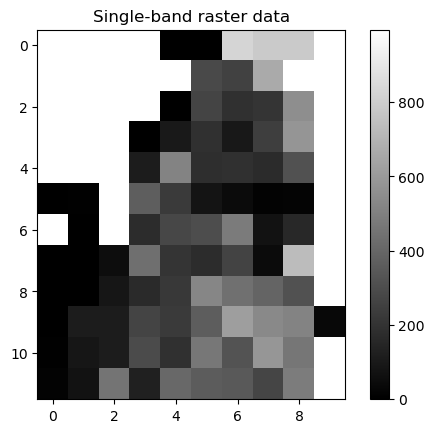

In [94]:
visualize_raster('B_Building_Heights_Sum.tif', missing_value = -1)

There is a slight difference due to rounding. So, it looks very similar.

### Write a new function to make average of a field and make raster file

In [158]:
def raster_average(shapefile_path, reference_raster_path, new_raser_path, field_name):
    import geopandas as gpd
    import rasterio
    import numpy as np
    
    # Step 0: Read the existing raster for bounds and transforms
    with rasterio.open(reference_raster_path) as existing_raster:
        transform = existing_raster.transform
        bounds = existing_raster.bounds
        cell_size = existing_raster.res[0]
        width = existing_raster.width
        height = existing_raster.height
        crs = existing_raster.crs
        
    # Step 1: Read the shapefile
    points = gpd.read_file(shapefile_path)
    
    # Step 2: Create the raster with the same extent as the existing raster
    with rasterio.open(new_raster_path, 'w', driver='GTiff', height=height, width=width,
                      count=1, dtype=rasterio.float32, crs=crs, transform=transform,
                      nodata=9999.0) as dst:
        sums = np.full((height, width), 9999.0, dtype=np.float32) # Initialize with NoData value
        counts = np.zeros((height, width), dtype=np.uint32)  
        
        for point, value in zip(points.geometry, points[field_name]):
            row, col = dst.index(point.x, point.y)
            if bounds.left <= point.x <= bounds.right and bounds.bottom <= point.y <= bounds.top:
                if 0 <= row < height and 0 <= col < width:
                    if sums[row, col] == 9999.0: # If currently NoData, make it 0 before summing
                        sums[row, col] = 0.0
                    sums[row, col] += value
                    counts[row, col] += 1
                        
        # Calculate averages ad assign 9999.0 to cells with count equal to 0
        averages = np.where(counts > 0, sums / counts, 9999.0)
        
        # Step 4: Write this sum to a raster file
        dst.write(averages, 1)

## Step C -- Build_Hgts_mean for each 500 m grid

In [96]:
def step_C(shapefile_path, reference_raster_path, new_raster_path):
    raster_average(shapefile_path, reference_raster_path, new_raster_path, 'Build_Hgt')

In [97]:
shapefile_path = 'MapPluto_small_boundary_WGS_Mercator_points.shp'
reference_raster_path = 'A_Building_Count.tif'
new_raster_path = 'C_Building_Heights_Mean_Same_Extent.tif'
step_C(shapefile_path, reference_raster_path, new_raster_path)

/tmp/ipykernel_3605356/2875240842.py:35: RuntimeWarning: divide by zero encountered in true_divide
  averages = np.where(counts > 0, sums / counts, 9999.0)


In [98]:
raster_as_numpy_array('C_Building_Heights_Mean_Same_Extent.tif')

[[[9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 0.0000000e+00
   0.0000000e+00 2.2454056e+01 3.0343269e+01 2.0185898e+01 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03
   7.2025002e+01 6.3650002e+01 1.8424997e+01 2.1169151e+01 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 0.0000000e+00
   5.2930004e+01 9.5474998e+01 6.8116669e+01 6.9093750e+01 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 0.0000000e+00 3.3500000e+01
   4.8575001e+01 4.8575001e+01 8.0400002e+01 5.2686363e+01 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 2.7637501e+01 5.0919998e+01
   2.0099998e+01 3.2383331e+01 8.3750000e+01 5.3041668e+01 9.9990000e+03]
  [0.0000000e+00 3.3499999e+00 9.9990000e+03 9.2125000e+01 7.5933334e+01
   2.0100000e+01 4.3549999e+01 1.3400000e+01 1.6750000e+01 9.9990000e+03]
  [9.9990000e+03 0.0000000e+00 9.9990000e+03 5.9183334e+01 6.9512497e+01
   5.0250000e+01 7.9841667e+01 3.5174999e+01 

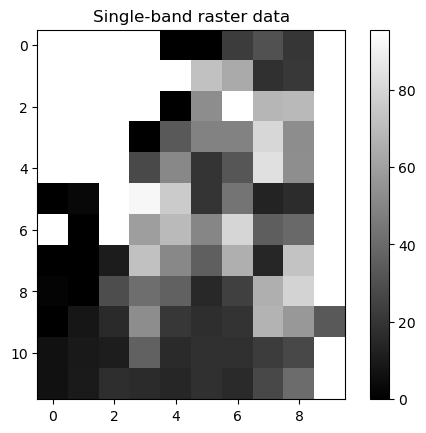

In [99]:
visualize_raster('C_Building_Heights_Mean_Same_Extent.tif', missing_value=9.99900000e+03)

Now compare it with output from ArcGIS (by Madhvi).

In [100]:
raster_as_numpy_array('C_Building_Heights_Mean.tif')

[[[-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    0.0000000e+00  0.0000000e+00  2.2454054e+01  3.0343269e+01
    2.0185898e+01 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
   -3.4028235e+38  7.2025002e+01  6.3650002e+01  1.8424999e+01
    2.1169149e+01 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    0.0000000e+00  5.2930000e+01  9.5475006e+01  6.8116669e+01
    6.9093750e+01 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  0.0000000e+00
    3.3500000e+01  4.8575001e+01  4.8575001e+01  8.0400002e+01
    5.2686363e+01 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  2.7637501e+01
    5.0920002e+01  2.0100000e+01  3.2383331e+01  8.3750000e+01
    5.3041664e+01 -3.4028235e+38]
  [ 0.0000000e+00  3.3499999e+00 -3.4028235e+38  9.2125000e+01
    7.5933334e+01  2.0100000e+01  4.3549999e+01  1.3400000e+01
    1.6750000e+01 -3.4028235e+38]
  [-3.4028235e+38  0.0000000e+00 -3.4028

/home/sislam27/.conda/envs/clim_data/lib/python3.10/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


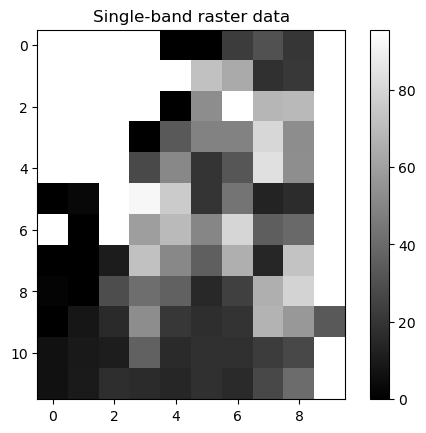

In [101]:
visualize_raster('C_Building_Heights_Mean.tif', missing_value=-1)

## Step D - Total_shape_area

In [159]:
def sum_total_area(shapefile_path, reference_raster_path, new_raser_path, field_name):
    import geopandas as gpd
    import rasterio
    import numpy as np
    
    # Step 0: Read the existing raster for bounds and transforms
    with rasterio.open(reference_raster_path) as existing_raster:
        transform = existing_raster.transform
        bounds = existing_raster.bounds
        cell_size = existing_raster.res[0]
        width = existing_raster.width
        height = existing_raster.height
        crs = existing_raster.crs
        
    # Step 1: Read the shapefile
    points = gpd.read_file(shapefile_path)
    
    # Step 2: Create the raster with the same extent as the existing raster
    with rasterio.open(new_raster_path, 'w', driver='GTiff', height=height, width=width,
                      count=1, dtype=rasterio.float32, crs=crs, transform=transform,
                      nodata=9999.0) as dst:
        sums = np.full((height, width), 9999.0, dtype=np.float32) # Initialize with NoData value
        for point, value1, value2 in zip(points.geometry, points[field_name], points['Build_Hgt']):
            row, col = dst.index(point.x, point.y)
            if bounds.left <= point.x <= bounds.right and bounds.bottom <= point.y <= bounds.top:
                if 0 <= row < height and 0 <= col < width:
                    if sums[row, col] == 9999.0: # If currently NoData, make it 0 before summing
                        sums[row, col] = 0.0
                    sums[row, col] += value1
                        
        # Step 4: Write this sum to a raster file
        dst.write(sums, 1)

In [103]:
def step_D(shapefile_path, reference_raster_path, new_raser_path):
    sum_total_area(shapefile_path, reference_raster_path, new_raser_path, 'Shape_Area')

In [104]:
shapefile_path = 'MapPluto_small_boundary_WGS_Mercator_points.shp'
reference_raster_path = 'A_Building_Count.tif'
new_raster_path = 'D_Total_Shape_Area_Same_Extent.tif'
step_D(shapefile_path, reference_raster_path, new_raster_path)

In [105]:
raster_as_numpy_array('D_Total_Shape_Area_Same_Extent.tif')

[[[9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   3.25178955e+03 3.00505219e+05 1.72569484e+05 1.20522969e+05
   1.55650469e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   9.99900000e+03 1.43323391e+05 2.07855078e+05 1.34429734e+05
   1.67789641e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   3.24823688e+05 1.90751750e+05 1.93793844e+05 3.20333406e+05
   1.03434469e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 1.35461562e+05
   8.32457422e+04 2.14317031e+05 1.31028164e+05 1.80553641e+05
   1.60092719e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 5.12654125e+05
   3.34632969e+05 1.60925250e+05 1.76852219e+05 1.41901047e+05
   2.02685094e+05 9.99900000e+03]
  [4.53259811e+01 1.07243258e+05 9.99900000e+03 2.29763625e+05
   1.22741852e+05 6.83232578e+04 4.17271031e+05 6.91274141e+04
   3.14998125e+05 9.99900000e+03]
  [9.99900000e+03 8.74056641e+04 9.99900

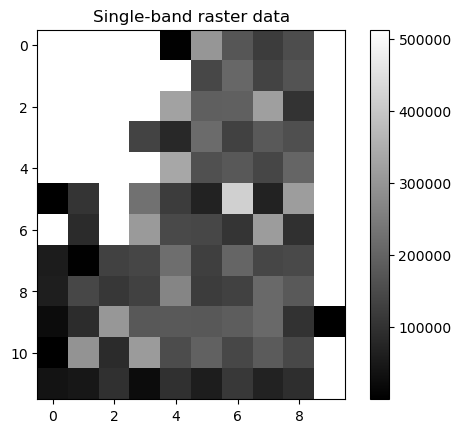

In [106]:
visualize_raster('D_Total_Shape_Area_Same_Extent.tif', missing_value=9.99900000e+03)

Now compare it with output from ArcGIS (by Madhvi).

In [107]:
raster_as_numpy_array('D_Total_Shape_Area.tif')

[[[-1.79769313e+308 -1.79769313e+308 -1.79769313e+308 -1.79769313e+308
    3.25178946e+003  3.00505229e+005  1.72569477e+005  1.20522957e+005
    1.55650458e+005 -1.79769313e+308]
  [-1.79769313e+308 -1.79769313e+308 -1.79769313e+308 -1.79769313e+308
   -1.79769313e+308  1.43323392e+005  2.07855071e+005  1.34429734e+005
    1.67789640e+005 -1.79769313e+308]
  [-1.79769313e+308 -1.79769313e+308 -1.79769313e+308 -1.79769313e+308
    3.24823675e+005  1.90751766e+005  1.93793849e+005  3.20333393e+005
    1.03434462e+005 -1.79769313e+308]
  [-1.79769313e+308 -1.79769313e+308 -1.79769313e+308  1.35461556e+005
    8.32457433e+004  2.14317033e+005  1.31028161e+005  1.80553641e+005
    1.60092711e+005 -1.79769313e+308]
  [-1.79769313e+308 -1.79769313e+308 -1.79769313e+308  5.12654112e+005
    3.34632967e+005  1.60925257e+005  1.76852220e+005  1.41901047e+005
    2.02685092e+005 -1.79769313e+308]
  [ 4.53259826e+001  1.07243260e+005 -1.79769313e+308  2.29763636e+005
    1.22741856e+005  6.832326

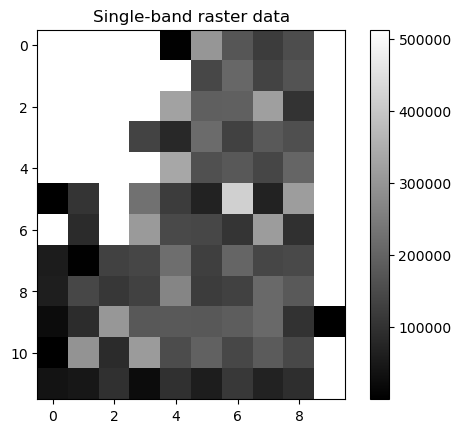

In [108]:
visualize_raster('D_Total_Shape_Area.tif', missing_value=-1)

So, they are pretty similar.

## Step E -- Build_vol_sum

In [109]:
def step_E(shapefile_path, reference_raster_path, new_raser_path):
    sum_total_area(shapefile_path, reference_raster_path, new_raser_path, 'Build_Vol')

In [110]:
shapefile_path = 'MapPluto_small_boundary_WGS_Mercator_points.shp'
reference_raster_path = 'A_Building_Count.tif'
new_raster_path = 'E_Building_Volume_Sum_Same_Extent.tif'
step_E(shapefile_path, reference_raster_path, new_raster_path)

In [111]:
raster_as_numpy_array('E_Building_Volume_Sum_Same_Extent.tif')

[[[9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 0.0000000e+00
   0.0000000e+00 1.1899902e+07 5.0977070e+06 4.5197030e+06 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03
   1.2336900e+07 1.8400842e+07 4.8589175e+06 4.8524790e+06 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 0.0000000e+00
   1.1505250e+07 1.8511310e+07 2.2214480e+07 1.0468549e+07 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 0.0000000e+00 3.0909500e+06
   7.7965800e+06 6.9687600e+06 1.9325760e+07 1.3401976e+07 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 4.8462600e+06 2.5239172e+07
   3.5030020e+06 6.5036630e+06 7.0731600e+06 9.3118760e+06 9.9990000e+03]
  [0.0000000e+00 4.4257800e+05 9.9990000e+03 2.5073640e+07 1.4047820e+07
   1.3201000e+06 1.8172200e+07 9.2630700e+05 5.2762200e+06 9.9990000e+03]
  [9.9990000e+03 0.0000000e+00 9.9990000e+03 1.7918484e+07 1.5644490e+07
   8.9549570e+06 5.5245210e+06 1.4148876e+07 

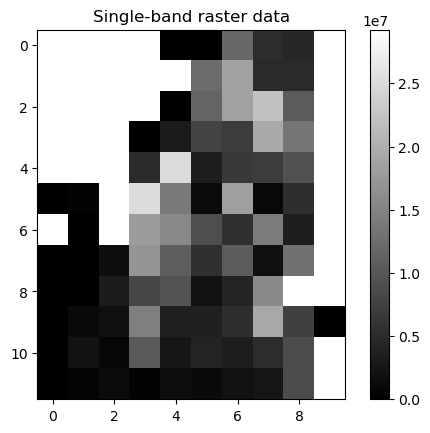

In [112]:
visualize_raster('E_Building_Volume_Sum_Same_Extent.tif', missing_value=9.99900000e+03)

Now, again, compare it with output from ArcGIS (by Madhvi).

In [113]:
raster_as_numpy_array('E_Building_Volume_Sum.tif')

[[[-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    0.0000000e+00  0.0000000e+00  1.1899902e+07  5.0977070e+06
    4.5197030e+06 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
   -3.4028235e+38  1.2336900e+07  1.8400842e+07  4.8589175e+06
    4.8524790e+06 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    0.0000000e+00  1.1505250e+07  1.8511310e+07  2.2214480e+07
    1.0468549e+07 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  0.0000000e+00
    3.0909500e+06  7.7965800e+06  6.9687600e+06  1.9325760e+07
    1.3401976e+07 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  4.8462600e+06
    2.5239172e+07  3.5030020e+06  6.5036630e+06  7.0731600e+06
    9.3118750e+06 -3.4028235e+38]
  [ 0.0000000e+00  4.4257800e+05 -3.4028235e+38  2.5073640e+07
    1.4047820e+07  1.3201000e+06  1.8172200e+07  9.2630700e+05
    5.2762200e+06 -3.4028235e+38]
  [-3.4028235e+38  0.0000000e+00 -3.4028

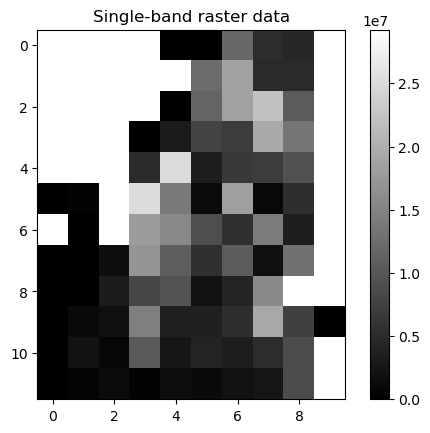

In [114]:
visualize_raster('E_Building_Volume_Sum.tif', missing_value=-1)

So they do look very similar.

## Step F - Build_area_sum (i.e., total area of roof and walls)

In [115]:
def step_F(shapefile_path, reference_raster_path, new_raser_path):
    sum_total_area(shapefile_path, reference_raster_path, new_raser_path, 'Build_Area')

In [116]:
shapefile_path = 'MapPluto_small_boundary_WGS_Mercator_points.shp'
reference_raster_path = 'A_Building_Count.tif'
new_raster_path = 'F_Building_Area_Sum_Same_Extent.tif'
step_F(shapefile_path, reference_raster_path, new_raster_path)

In [117]:
raster_as_numpy_array('F_Building_Area_Sum_Same_Extent.tif')

[[[9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   3.25179004e+03 3.00505594e+05 5.39078938e+05 3.76686906e+05
   4.11566625e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   9.99900000e+03 3.84271188e+05 4.91489656e+05 3.64432000e+05
   4.73972656e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   3.24823906e+05 4.16203000e+05 4.34480000e+05 6.93513000e+05
   4.07458656e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 1.35461094e+05
   1.54882000e+05 3.93129812e+05 2.49494203e+05 5.40073750e+05
   5.08035469e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 6.05568125e+05
   8.04411188e+05 2.66581594e+05 3.15425000e+05 2.92368000e+05
   4.41250500e+05 9.99900000e+03]
  [4.53260002e+01 1.21123398e+05 9.99900000e+03 6.20964625e+05
   3.62054594e+05 1.10463297e+05 5.60494000e+05 8.33552969e+04
   3.66269000e+05 9.99900000e+03]
  [9.99900000e+03 8.74056797e+04 9.99900

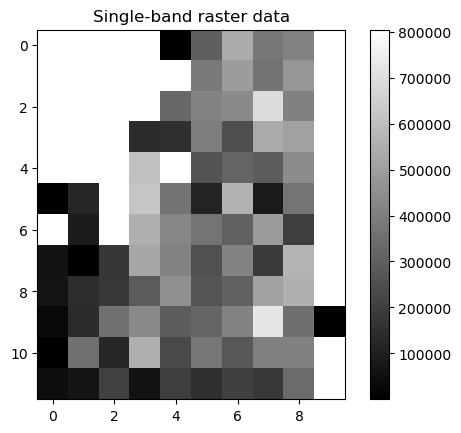

In [118]:
visualize_raster('F_Building_Area_Sum_Same_Extent.tif', missing_value=9.99900000e+03)

Now, again, compare it with output from ArcGIS (by Madhvi).

In [119]:
raster_as_numpy_array('F_Building_Area_Sum.tif')

[[[-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    3.2517900e+03  3.0050562e+05  5.3907894e+05  3.7668691e+05
    4.1156659e+05 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
   -3.4028235e+38  3.8427119e+05  4.9148962e+05  3.6443194e+05
    4.7397275e+05 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    3.2482391e+05  4.1620300e+05  4.3448000e+05  6.9351300e+05
    4.0745866e+05 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  1.3546109e+05
    1.5488200e+05  3.9312981e+05  2.4949420e+05  5.4007375e+05
    5.0803550e+05 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  6.0556812e+05
    8.0441119e+05  2.6658159e+05  3.1542500e+05  2.9236800e+05
    4.4125050e+05 -3.4028235e+38]
  [ 4.5326000e+01  1.2112341e+05 -3.4028235e+38  6.2096462e+05
    3.6205459e+05  1.1046330e+05  5.6049400e+05  8.3355297e+04
    3.6626900e+05 -3.4028235e+38]
  [-3.4028235e+38  8.7405680e+04 -3.4028

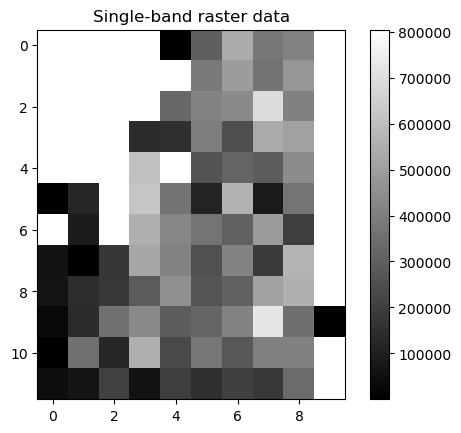

In [120]:
visualize_raster('F_Building_Area_Sum.tif', missing_value=-1)

Again, the pattern looks very similar.

### Create the file x_MapPLUTO_small_boundary_intermediary.shp 

Now, we will add/compute Mean_Hgt, Build_Dev (building height - mean height), Bui_Dev_Sq, heights in 38 bins for 0-190m heights, area in 38 bins for 0-190m heights.

#### First, add Mean_Hgt to shapefile

In [171]:
def add_mean_height_to_shapefile(shapefile_path, raster_path, new_field_name):
    
    import geopandas as gpd
    import rasterio
    import numpy as np
    
    # Step 1: Read the raster data
    with rasterio.open(raster_path)as src:
        raster_data = src.read(1) # Read the first band
        transform = src.transform
        
    # Step 2: Read the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Step 3: Assign the mean height value from the raster to each point
    mean_heights = []
    
    for point in gdf.geometry:
        row, col = src.index(point.x, point.y)
        mean_height = raster_data[row, col]
        
        # Handle NoData values in the raster
        if mean_height == 9999.0:
            mean_height = np.nan # or use any other placeholder for NoData
            
        mean_heights.append(mean_height)
        
    # Add the new field with mean heights to the GeoDataFrame
    gdf[new_field_name] = mean_heights
    
    return gdf

In [172]:
shapefile_path = 'MapPluto_small_boundary_WGS_Mercator_points.shp'
raster_path = 'C_Building_Heights_Mean_Same_Extent.tif'
new_field_name = 'Mean_hgt'
new_shp_mean_hgt = add_mean_height_to_shapefile(shapefile_path, raster_path, new_field_name)

In [173]:
new_shp_mean_hgt.head(20)

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Notes,Shape_Leng,Shape_Area,Build_Hgt,Wall_Area,Build_Area,Build_Vol,ORIG_FID,geometry,Mean_hgt
0,MN,1026,54,105,1013700,10137006002,137,3002,02,3,...,None,185.851400,1430.948061,13.40,2490.41,3921.36,19174.7,0,POINT (988971.462 217933.347),40.479168
1,MN,1026,55,105,1013700,10137006002,137,3002,02,3,...,None,825.987541,37426.677125,134.00,110682.00,148109.00,5015170.0,1,POINT (988813.386 217971.898),40.479168
2,MN,1026,7502,105,1013700,10137006002,137,3002,02,3,...,None,322.876961,3967.281496,103.85,33530.80,37498.10,412002.0,2,POINT (989022.076 217921.097),40.479168
3,MN,1027,1,105,1013700,10137006001,137,3001,02,3,...,None,166.377878,1246.335002,16.75,2786.83,4033.17,20876.1,3,POINT (988816.357 218135.607),40.479168
4,MN,1027,2,105,1013700,10137006001,137,3001,02,3,...,None,166.178637,1239.994844,16.75,2783.49,4023.48,20769.9,4,POINT (988825.718 218152.771),40.479168
5,MN,1027,3,105,1013700,10137006001,137,3001,02,3,...,None,162.549832,1124.628945,16.75,2722.71,3847.34,18837.5,5,POINT (988843.940 218186.224),26.997057
6,MN,1027,4,105,1013700,10137006001,137,3001,02,3,...,None,259.538138,2693.072550,10.05,2608.36,5301.43,27065.4,6,POINT (988872.042 218195.588),26.997057
7,MN,1027,5,105,1013700,10137006001,137,3001,02,3,...,None,247.604529,2207.408739,16.75,4147.38,6354.79,36974.1,7,POINT (988908.672 218131.747),40.479168
8,MN,1027,6,105,1013700,10137006001,137,3001,02,3,...,None,242.604256,1952.038205,6.70,1625.45,3577.49,13078.7,8,POINT (988926.480 218121.898),40.479168
9,MN,1027,7,105,1013700,10137006001,137,3001,02,3,...,None,328.687161,6350.894885,36.85,12112.10,18463.00,234030.0,9,POINT (988962.025 218102.236),40.479168


#### Now, add deviation of building height from average building height

In [174]:
new_shp_mean_hgt['Build_Dev'] = new_shp_mean_hgt['Build_Hgt'] - new_shp_mean_hgt['Mean_hgt']
new_shp_mean_hgt.head(10)

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Shape_Leng,Shape_Area,Build_Hgt,Wall_Area,Build_Area,Build_Vol,ORIG_FID,geometry,Mean_hgt,Build_Dev
0,MN,1026,54,105,1013700,10137006002,137,3002,02,3,...,185.851400,1430.948061,13.40,2490.41,3921.36,19174.7,0,POINT (988971.462 217933.347),40.479168,-27.079168
1,MN,1026,55,105,1013700,10137006002,137,3002,02,3,...,825.987541,37426.677125,134.00,110682.00,148109.00,5015170.0,1,POINT (988813.386 217971.898),40.479168,93.520832
2,MN,1026,7502,105,1013700,10137006002,137,3002,02,3,...,322.876961,3967.281496,103.85,33530.80,37498.10,412002.0,2,POINT (989022.076 217921.097),40.479168,63.370832
3,MN,1027,1,105,1013700,10137006001,137,3001,02,3,...,166.377878,1246.335002,16.75,2786.83,4033.17,20876.1,3,POINT (988816.357 218135.607),40.479168,-23.729168
4,MN,1027,2,105,1013700,10137006001,137,3001,02,3,...,166.178637,1239.994844,16.75,2783.49,4023.48,20769.9,4,POINT (988825.718 218152.771),40.479168,-23.729168
5,MN,1027,3,105,1013700,10137006001,137,3001,02,3,...,162.549832,1124.628945,16.75,2722.71,3847.34,18837.5,5,POINT (988843.940 218186.224),26.997057,-10.247057
6,MN,1027,4,105,1013700,10137006001,137,3001,02,3,...,259.538138,2693.072550,10.05,2608.36,5301.43,27065.4,6,POINT (988872.042 218195.588),26.997057,-16.947057
7,MN,1027,5,105,1013700,10137006001,137,3001,02,3,...,247.604529,2207.408739,16.75,4147.38,6354.79,36974.1,7,POINT (988908.672 218131.747),40.479168,-23.729168
8,MN,1027,6,105,1013700,10137006001,137,3001,02,3,...,242.604256,1952.038205,6.70,1625.45,3577.49,13078.7,8,POINT (988926.480 218121.898),40.479168,-33.779168
9,MN,1027,7,105,1013700,10137006001,137,3001,02,3,...,328.687161,6350.894885,36.85,12112.10,18463.00,234030.0,9,POINT (988962.025 218102.236),40.479168,-3.629168


In [175]:
new_shp_mean_hgt['Bu_Dev_Sq'] = new_shp_mean_hgt['Build_Dev']**2
new_shp_mean_hgt.head(4)

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Shape_Area,Build_Hgt,Wall_Area,Build_Area,Build_Vol,ORIG_FID,geometry,Mean_hgt,Build_Dev,Bu_Dev_Sq
0,MN,1026,54,105,1013700,10137006002,137,3002,02,3,...,1430.948061,13.40,2490.41,3921.36,19174.7,0,POINT (988971.462 217933.347),40.479168,-27.079168,733.281336
1,MN,1026,55,105,1013700,10137006002,137,3002,02,3,...,37426.677125,134.00,110682.00,148109.00,5015170.0,1,POINT (988813.386 217971.898),40.479168,93.520832,8746.146030
2,MN,1026,7502,105,1013700,10137006002,137,3002,02,3,...,3967.281496,103.85,33530.80,37498.10,412002.0,2,POINT (989022.076 217921.097),40.479168,63.370832,4015.862356
3,MN,1027,1,105,1013700,10137006001,137,3001,02,3,...,1246.335002,16.75,2786.83,4033.17,20876.1,3,POINT (988816.357 218135.607),40.479168,-23.729168,563.073411


#### Make 38 bins for 0-190m heights

In [176]:
import pandas as pd
import numpy as np

# A function determining whether height is within a bound and assigns that height value, otherwise assigns 0
def value_in_range(row, lower_bound, upper_bound, column_name):
    if lower_bound <= row[column_name] < upper_bound:
        return row[column_name]
    else:
        return 0
    
# Now, loop over the ranges at a space of 5 and and create new columns
for lower_bound in range(0, 186, 5):
    upper_bound = lower_bound + 5
    column_name = f'Hgt_{lower_bound}_{upper_bound}'
    new_shp_mean_hgt[column_name] = new_shp_mean_hgt.apply(value_in_range, axis=1, lower_bound=lower_bound, upper_bound=upper_bound, column_name='Build_Hgt')

In [177]:
new_shp_mean_hgt.head(25)

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Hgt_140_145,Hgt_145_150,Hgt_150_155,Hgt_155_160,Hgt_160_165,Hgt_165_170,Hgt_170_175,Hgt_175_180,Hgt_180_185,Hgt_185_190
0,MN,1026,54,105,1013700,10137006002,137,3002,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0
1,MN,1026,55,105,1013700,10137006002,137,3002,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0
2,MN,1026,7502,105,1013700,10137006002,137,3002,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0
3,MN,1027,1,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0
4,MN,1027,2,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0
5,MN,1027,3,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0
6,MN,1027,4,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0
7,MN,1027,5,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0
8,MN,1027,6,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0
9,MN,1027,7,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0


#### Make 38 bins for 0-190m Area

In [178]:
# A function determining whether height is within a bound and assigns corresponding area value, otherwise assigns 0
def value_in_range(row, lower_bound, upper_bound, column_name):
    if lower_bound <= row['Build_Hgt'] < upper_bound:
        return row[column_name]
    else:
        return 0

# Now, loop over the ranges at a space of 5 and and create new columns
for lower_bound in range(0, 186, 5):
    upper_bound = lower_bound + 5
    column_name = f'Ar_{lower_bound}_{upper_bound}'
    new_shp_mean_hgt[column_name] = new_shp_mean_hgt.apply(value_in_range, axis=1, lower_bound=lower_bound, upper_bound=upper_bound, column_name='Shape_Area')

In [179]:
new_shp_mean_hgt.head(25)

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Ar_140_145,Ar_145_150,Ar_150_155,Ar_155_160,Ar_160_165,Ar_165_170,Ar_170_175,Ar_175_180,Ar_180_185,Ar_185_190
0,MN,1026,54,105,1013700,10137006002,137,3002,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0
1,MN,1026,55,105,1013700,10137006002,137,3002,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0
2,MN,1026,7502,105,1013700,10137006002,137,3002,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0
3,MN,1027,1,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0
4,MN,1027,2,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0
5,MN,1027,3,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0
6,MN,1027,4,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0
7,MN,1027,5,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0
8,MN,1027,6,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0
9,MN,1027,7,105,1013700,10137006001,137,3001,02,3,...,0.0,0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0.0


#### Now, save this shapefile

In [180]:
new_shp_mean_hgt.to_file("x_Mean_building_height_points_Sha.shp")

/tmp/ipykernel_3605356/1227216530.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  new_shp_mean_hgt.to_file("x_Mean_building_height_points_Sha.shp")


#### Plot this new shapefile

<AxesSubplot:>

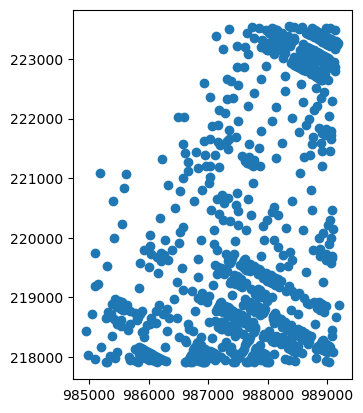

In [181]:
import geopandas as gpd
x_shp_sha = gpd.read_file('x_Mean_building_height_points_Sha.shp')
x_shp_sha.plot()

<AxesSubplot:>

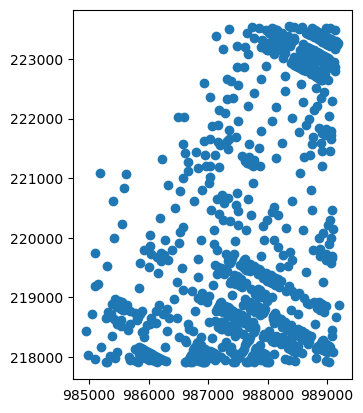

In [182]:
x_shp_madhvi = gpd.read_file('x_Mean_building_height_points.shp')
x_shp_madhvi.plot()

#### Making rasters for 5m_area_bins_sum 

In [183]:
new_shp_mean_hgt.columns.tolist()

['Borough',
 'Block',
 'Lot',
 'CD',
 'BCT2020',
 'BCTCB2020',
 'CT2010',
 'CB2010',
 'SchoolDist',
 'Council',
 'ZipCode',
 'Address',
 'LandUse',
 'OwnerName',
 'LotArea',
 'BldgArea',
 'ComArea',
 'ResArea',
 'OfficeArea',
 'RetailArea',
 'GarageArea',
 'StrgeArea',
 'FactryArea',
 'OtherArea',
 'AreaSource',
 'NumBldgs',
 'NumFloors',
 'UnitsRes',
 'UnitsTotal',
 'LotFront',
 'LotDepth',
 'BldgFront',
 'BldgDepth',
 'Ext',
 'ProxCode',
 'IrrLotCode',
 'LotType',
 'BsmtCode',
 'AssessLand',
 'AssessTot',
 'ExemptTot',
 'YearBuilt',
 'YearAlter1',
 'YearAlter2',
 'HistDist',
 'Landmark',
 'BuiltFAR',
 'ResidFAR',
 'CommFAR',
 'FacilFAR',
 'BoroCode',
 'BBL',
 'CondoNo',
 'Tract2010',
 'XCoord',
 'YCoord',
 'ZoneMap',
 'ZMCode',
 'Sanborn',
 'TaxMap',
 'EDesigNum',
 'APPBBL',
 'APPDate',
 'PLUTOMapID',
 'FIRM07_FLA',
 'PFIRM15_FL',
 'Version',
 'DCPEdited',
 'Latitude',
 'Longitude',
 'Notes',
 'Shape_Leng',
 'Shape_Area',
 'Build_Hgt',
 'Wall_Area',
 'Build_Area',
 'Build_Vol',
 'ORI

In [184]:
def generate_rasters_for_all_areas(shapefile_path, reference_raster_path, base_raster_path):
    import geopandas as gpd
    import rasterio
    import numpy as np

    # Read the existing raster for bounds and transforms
    with rasterio.open(reference_raster_path) as existing_raster:
        transform = existing_raster.transform
        bounds = existing_raster.bounds
        width = existing_raster.width
        height = existing_raster.height
        crs = existing_raster.crs

    # Read the shapefile
    points = gpd.read_file(shapefile_path)

    # Loop over each area range
    for lower_bound in range(0, 186, 5):
        upper_bound = lower_bound + 5
        field_name = f'Ar_{lower_bound}_{upper_bound}'

        # Check if field exists
        if field_name not in points.columns:
            print(f"Field {field_name} not found in the shapefile.")
            continue

        new_raster_path = f'{base_raster_path}/Sum_area_{lower_bound}_{upper_bound}_build_hgt_Sha.tif'

        # Create the raster for the current field
        with rasterio.open(new_raster_path, 'w', driver='GTiff', height=height, width=width,
                          count=1, dtype=rasterio.float32, crs=crs, transform=transform,
                          nodata=9999.0) as dst:
            sums = np.full((height, width), 9999.0, dtype=np.float32)  # Initialize with NoData value
            for point, value in zip(points.geometry, points[field_name]):
                row, col = dst.index(point.x, point.y)
                if bounds.left <= point.x <= bounds.right and bounds.bottom <= point.y <= bounds.top:
                    if 0 <= row < height and 0 <= col < width:
                        if sums[row, col] == 9999.0:  # If currently NoData, make it 0 before summing
                            sums[row, col] = 0.0
                        sums[row, col] += value

            # Write the sum to the raster file
            dst.write(sums, 1)

shapefile_path = 'x_Mean_building_height_points_Sha.shp'
reference_raster_path = 'A_Building_Count.tif'
base_raster_path = './Dist_building_hgts/Sum_area_bins_build_hgt'
generate_rasters_for_all_areas(shapefile_path, reference_raster_path, base_raster_path)

In [185]:
raster_as_numpy_array('D_Total_Shape_Area_Same_Extent.tif')

[[[9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   3.25178955e+03 3.00505219e+05 1.72569484e+05 1.20522969e+05
   1.55650469e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   9.99900000e+03 1.43323391e+05 2.07855078e+05 1.34429734e+05
   1.67789641e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   3.24823688e+05 1.90751750e+05 1.93793844e+05 3.20333406e+05
   1.03434469e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 1.35461562e+05
   8.32457422e+04 2.14317031e+05 1.31028164e+05 1.80553641e+05
   1.60092719e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 5.12654125e+05
   3.34632969e+05 1.60925250e+05 1.76852219e+05 1.41901047e+05
   2.02685094e+05 9.99900000e+03]
  [4.53259811e+01 1.07243258e+05 9.99900000e+03 2.29763625e+05
   1.22741852e+05 6.83232578e+04 4.17271031e+05 6.91274141e+04
   3.14998125e+05 9.99900000e+03]
  [9.99900000e+03 8.74056641e+04 9.99900

In [136]:
raster_as_numpy_array('./Dist_building_hgts/Sum_area_bins_build_hgt/Sum_area_0_5_build_hgt.tif') 

[[[-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    3.2517900e+03  3.0050562e+05  1.2328700e+03  2.7856100e+01
    2.8480480e+04 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
   -3.4028235e+38  5.7008199e+04  0.0000000e+00  1.6866500e+03
    0.0000000e+00 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    3.2482391e+05  5.8049297e+04  0.0000000e+00  0.0000000e+00
    4.3208301e+03 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  1.3546109e+05
    5.2490000e+04  4.7606301e+04  5.9296199e+04  5.2745498e+03
    9.0469297e+03 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  4.6881609e+05
    1.0630690e+05  8.5699297e+04  3.2142699e+04  0.0000000e+00
    0.0000000e+00 -3.4028235e+38]
  [ 4.5326000e+01  4.1186801e+04 -3.4028235e+38  2.5744600e+04
    1.4982700e+04  0.0000000e+00  0.0000000e+00  0.0000000e+00
    0.0000000e+00 -3.4028235e+38]
  [-3.4028235e+38  8.7405680e+04 -3.4028

In [138]:
raster_as_numpy_array('D_Total_Shape_Area.tif') 

[[[-1.79769313e+308 -1.79769313e+308 -1.79769313e+308 -1.79769313e+308
    3.25178946e+003  3.00505229e+005  1.72569477e+005  1.20522957e+005
    1.55650458e+005 -1.79769313e+308]
  [-1.79769313e+308 -1.79769313e+308 -1.79769313e+308 -1.79769313e+308
   -1.79769313e+308  1.43323392e+005  2.07855071e+005  1.34429734e+005
    1.67789640e+005 -1.79769313e+308]
  [-1.79769313e+308 -1.79769313e+308 -1.79769313e+308 -1.79769313e+308
    3.24823675e+005  1.90751766e+005  1.93793849e+005  3.20333393e+005
    1.03434462e+005 -1.79769313e+308]
  [-1.79769313e+308 -1.79769313e+308 -1.79769313e+308  1.35461556e+005
    8.32457433e+004  2.14317033e+005  1.31028161e+005  1.80553641e+005
    1.60092711e+005 -1.79769313e+308]
  [-1.79769313e+308 -1.79769313e+308 -1.79769313e+308  5.12654112e+005
    3.34632967e+005  1.60925257e+005  1.76852220e+005  1.41901047e+005
    2.02685092e+005 -1.79769313e+308]
  [ 4.53259826e+001  1.07243260e+005 -1.79769313e+308  2.29763636e+005
    1.22741856e+005  6.832326

In [137]:
raster_as_numpy_array('./Dist_building_hgts/UCP2_Dist_build_Hgt_UCPs/UCP2_Dist_Build_Hgts_0_5m.tif') 

[[[-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    1.0000001e+00  1.0000013e+00  7.1441946e-03  2.3112693e-04
    1.8297717e-01 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
   -3.4028235e+38  3.9775923e-01  0.0000000e+00  1.2546703e-02
    0.0000000e+00 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    1.0000007e+00  3.0431852e-01  0.0000000e+00  0.0000000e+00
    4.1773602e-02 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  9.9999654e-01
    6.3054276e-01  2.2213027e-01  4.5254543e-01  2.9213201e-02
    5.6510568e-02 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  9.1448808e-01
    3.1768209e-01  5.3254104e-01  1.8174891e-01  0.0000000e+00
    0.0000000e+00 -3.4028235e+38]
  [ 1.0000005e+00  3.8405025e-01 -3.4028235e+38  1.1204819e-01
    1.2206675e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
    0.0000000e+00 -3.4028235e+38]
  [-3.4028235e+38  1.0000001e+00 -3.4028

In [139]:
1.2328700e+03 / 1.72569477e+005

0.007144195030503568

In [140]:
raster_as_numpy_array('./Dist_building_hgts/Sum_area_bins_build_hgt/Sum_area_0_5_build_hgt_Sha.tif') 

[[[9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 3.2517896e+03
   3.0050522e+05 1.2328748e+03 2.7856058e+01 2.8480461e+04 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03
   5.7008184e+04 0.0000000e+00 1.6866505e+03 0.0000000e+00 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 3.2482369e+05
   5.8049234e+04 0.0000000e+00 0.0000000e+00 4.3208350e+03 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 1.3546156e+05 5.2489984e+04
   4.7606348e+04 5.9296164e+04 5.2745493e+03 9.0469287e+03 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 4.6881638e+05 1.0630681e+05
   8.5699312e+04 3.2142713e+04 0.0000000e+00 0.0000000e+00 9.9990000e+03]
  [4.5325981e+01 4.1186797e+04 9.9990000e+03 2.5744631e+04 1.4982650e+04
   0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9990000e+03]
  [9.9990000e+03 8.7405664e+04 9.9990000e+03 1.6383655e+05 2.0536379e+04
   7.4691221e+03 2.2396266e+04 1.0664943e+05 

In [141]:
raster_as_numpy_array('D_Total_Shape_Area_Same_Extent.tif') 

[[[9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   3.25178955e+03 3.00505219e+05 1.72569484e+05 1.20522969e+05
   1.55650469e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   9.99900000e+03 1.43323391e+05 2.07855078e+05 1.34429734e+05
   1.67789641e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   3.24823688e+05 1.90751750e+05 1.93793844e+05 3.20333406e+05
   1.03434469e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 1.35461562e+05
   8.32457422e+04 2.14317031e+05 1.31028164e+05 1.80553641e+05
   1.60092719e+05 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 5.12654125e+05
   3.34632969e+05 1.60925250e+05 1.76852219e+05 1.41901047e+05
   2.02685094e+05 9.99900000e+03]
  [4.53259811e+01 1.07243258e+05 9.99900000e+03 2.29763625e+05
   1.22741852e+05 6.83232578e+04 4.17271031e+05 6.91274141e+04
   3.14998125e+05 9.99900000e+03]
  [9.99900000e+03 8.74056641e+04 9.99900

## UCP 1 -- B÷A (or simply C)

We have already computed this. This is the file **C_Building_Heights_Mean_Same_Extent.tif**.

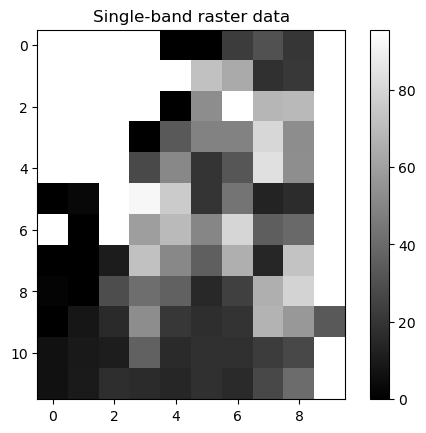

In [147]:
visualize_raster('C_Building_Heights_Mean_Same_Extent.tif', missing_value=9.99900000e+03)

## UCP 2 -- 5m_area_bins_sum ÷ D [38 bins for 0-190m heights; therefore 38 UCP 2 outputs] 

In [186]:
import rasterio
import numpy as np

# Base paths and filenames'
base_path = './Dist_building_hgts/Sum_area_bins_build_hgt/'
output_base_path = './Dist_building_hgts/UCP2_Dist_build_Hgt_UCPs/'
tiff2_path = 'D_Total_Shape_Area_Same_Extent.tif'

# Open the second tiff file
with rasterio.open(tiff2_path) as src2:
    tiff2_data = src2.read(1)
    nodata = 9999.0
    
# Loop through the range of files
for lower_bound in range(0, 186, 5):
    upper_bound = lower_bound + 5
    
    # Now, specify the file paths
    tiff1_path = f'{base_path}Sum_area_{lower_bound}_{upper_bound}_build_hgt_Sha.tif'
    output_tiff_path = f'{output_base_path}UCP2_Dist_Build_Hgts_{lower_bound}_{upper_bound}m_Sha.tif'
    
    # Open and read the tiff file
    with rasterio.open(tiff1_path) as src1:
        tiff1_data = src1.read(1)
        meta = src1.meta
    
    # Perform division except the NoData values
    result = np.where((tiff1_data != nodata) & (tiff2_data != nodata) & (tiff2_data != 0),
                     tiff1_data / tiff2_data, nodata)
    
    # Update metadata for output raster and write the result as tiff file
    meta.update(dtype = rasterio.float32)
    with rasterio.open(output_tiff_path, 'w', **meta) as dst:
        dst.write(result, 1)
    

### UCP 3 -- E ÷ D

In [187]:
import rasterio
import numpy as np

# Paths to tiff files
tiff1_path = 'E_Building_Volume_Sum_Same_Extent.tif'
tiff2_path = 'D_Total_Shape_Area_Same_Extent.tif'
output_tiff_path = 'UCP3_Area_Weighted_Mean_Building_Height_Sha.tif'

# Open the first TIFF file
with rasterio.open(tiff1_path) as src1:
    tiff1_data = src1.read(1)
    meta = src1.meta
    
# Open the second TIFf file'
with rasterio.open(tiff2_path) as src2:
    tiff2_data = src2.read(1)
    
# Set nodata value
nodata = 9999.0

# Perform division by handling with nodata values
result = np.where((tiff1_data != nodata) & (tiff2_data != nodata) & (tiff2_data != 0),
                 tiff1_data / tiff2_data, nodata)

# Update metadata for output raster
meta.update(dtype = rasterio.float32)

# Write the result to a new tiff file
with rasterio.open(output_tiff_path, 'w', **meta) as dst:
    dst.write(result, 1)

In [149]:
raster_as_numpy_array('UCP3_Area_Weighted_Mean_Building_Height_Sha.tif') 

[[[9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   0.00000000e+00 0.00000000e+00 6.89571609e+01 4.22965584e+01
   2.90375156e+01 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   9.99900000e+03 8.60773697e+01 8.85272675e+01 3.61446648e+01
   2.89200153e+01 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.99900000e+03
   0.00000000e+00 6.03153038e+01 9.55206299e+01 6.93479996e+01
   1.01209480e+02 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 0.00000000e+00
   3.71304283e+01 3.63787231e+01 5.31852074e+01 1.07036110e+02
   8.37138367e+01 9.99900000e+03]
  [9.99900000e+03 9.99900000e+03 9.99900000e+03 9.45327377e+00
   7.54234467e+01 2.17678833e+01 3.67745628e+01 4.98457222e+01
   4.59425812e+01 9.99900000e+03]
  [0.00000000e+00 4.12686062e+00 9.99900000e+03 1.09127975e+02
   1.14450127e+02 1.93213863e+01 4.35501099e+01 1.33999949e+01
   1.67500038e+01 9.99900000e+03]
  [9.99900000e+03 0.00000000e+00 9.99900

In [150]:
raster_as_numpy_array('UCP3_Area_Weighted_Mean_Building_Height.tif')

[[[-3.40282347e+38 -3.40282347e+38 -3.40282347e+38 -3.40282347e+38
    0.00000000e+00  0.00000000e+00  6.89571609e+01  4.22965660e+01
    2.90375195e+01 -3.40282347e+38]
  [-3.40282347e+38 -3.40282347e+38 -3.40282347e+38 -3.40282347e+38
   -3.40282347e+38  8.60773697e+01  8.85272675e+01  3.61446648e+01
    2.89200153e+01 -3.40282347e+38]
  [-3.40282347e+38 -3.40282347e+38 -3.40282347e+38 -3.40282347e+38
    0.00000000e+00  6.03153000e+01  9.55206299e+01  6.93479996e+01
    1.01209488e+02 -3.40282347e+38]
  [-3.40282347e+38 -3.40282347e+38 -3.40282347e+38  0.00000000e+00
    3.71304283e+01  3.63787231e+01  5.31852074e+01  1.07036110e+02
    8.37138443e+01 -3.40282347e+38]
  [-3.40282347e+38 -3.40282347e+38 -3.40282347e+38  9.45327377e+00
    7.54234467e+01  2.17678833e+01  3.67745628e+01  4.98457222e+01
    4.59425735e+01 -3.40282347e+38]
  [ 0.00000000e+00  4.12686062e+00 -3.40282347e+38  1.09127968e+02
    1.14450119e+02  1.93213863e+01  4.35501099e+01  1.33999949e+01
    1.67500038e+

### UCP 4

In [188]:
shapefile_path = 'x_Mean_building_height_points_Sha.shp'
reference_raster_path = 'A_Building_Count.tif'
new_raster_path = 'Building_Heights_Dev_Same_Extent.tif'
raster_average(shapefile_path, reference_raster_path, new_raster_path, 'Bu_Dev_Sq')

/tmp/ipykernel_3605356/2875240842.py:35: RuntimeWarning: divide by zero encountered in true_divide
  averages = np.where(counts > 0, sums / counts, 9999.0)


In [189]:
import rasterio
import numpy as np

# Paths to tiff files
tiff1_path = 'Building_Heights_Dev_Same_Extent.tif'
tiff2_path = 'A_Building_Count_Same_Extent.tif'
output_tiff_path = 'UCP4_StdDev_Building_Height_Sha.tif'

# Open the first TIFF file
with rasterio.open(tiff1_path) as src1:
    tiff1_data = src1.read(1)
    meta = src1.meta
    
# Open the second TIFf file'
with rasterio.open(tiff2_path) as src2:
    tiff2_data = src2.read(1)
    
# Set nodata value
nodata = 9999.0

# Perform division by handling with nodata values
result = np.where((tiff1_data != nodata) & (tiff2_data != nodata) & (tiff2_data != 0),
                 np.sqrt(tiff1_data / tiff2_data), nodata)

# Update metadata for output raster
meta.update(dtype = rasterio.float32)

# Write the result to a new tiff file
with rasterio.open(output_tiff_path, 'w', **meta) as dst:
    dst.write(result, 1)

In [190]:
raster_as_numpy_array('UCP4_StdDev_Building_Height_Sha.tif')

[[[9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 0.0000000e+00
   0.0000000e+00 4.7009044e+00 3.7034326e+00 2.6461072e+00 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03
   3.6187366e+01 1.6666039e+01 2.8996930e+00 2.0561943e+00 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 9.9990000e+03 0.0000000e+00
   2.0286732e+01 1.1844039e+00 2.3705616e+01 2.1087191e+01 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 0.0000000e+00 2.7352636e+01
   2.0870392e+01 3.4347713e+01 3.3088020e+01 1.4510502e+01 9.9990000e+03]
  [9.9990000e+03 9.9990000e+03 9.9990000e+03 2.3934776e+01 1.8704884e+01
   8.4388609e+00 1.1351252e+01 4.7376156e+01 1.4927805e+01 9.9990000e+03]
  [0.0000000e+00 2.3688078e+00 9.9990000e+03 2.6865349e+01 3.4102543e+01
   3.5532117e+00 7.6288921e-07 3.8209947e-07 0.0000000e+00 9.9990000e+03]
  [9.9990000e+03 0.0000000e+00 9.9990000e+03 3.5535042e+01 2.9784285e+01
   1.6879774e+01 3.1250875e+01 2.2503674e+01 

In [163]:
raster_as_numpy_array('UCP4_StdDev_Building_Height.tif')

[[[-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
   -3.4028235e+38  0.0000000e+00  2.8988907e+01  1.9257847e+01
    1.6740961e+01 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
   -3.4028235e+38  8.3571144e+01  3.8488556e+01  1.7644951e+01
    1.4248951e+01 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
    0.0000000e+00  5.0716801e+01  2.3688056e+00  5.0287205e+01
    6.3761642e+01 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  0.0000000e+00
    5.8023701e+01  4.8198105e+01  6.8695412e+01  7.0190292e+01
    5.0474926e+01 -3.4028235e+38]
  [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38  5.5274986e+01
    6.2349632e+01  2.6852287e+01  3.0458607e+01  9.4752312e+01
    4.0055500e+01 -3.4028235e+38]
  [-3.4028235e+38  4.7376156e+00 -3.4028235e+38  6.2042892e+01
    7.2342415e+01  8.2058115e+00 -3.4028235e+38 -3.4028235e+38
   -3.4028235e+38 -3.4028235e+38]
  [-3.4028235e+38  0.0000000e+00 -3.4028

In [169]:
x_shp = gpd.read_file('x_Mean_building_height_points_Sha.shp')
x_shp.columns.tolist()

['Borough',
 'Block',
 'Lot',
 'CD',
 'BCT2020',
 'BCTCB2020',
 'CT2010',
 'CB2010',
 'SchoolDist',
 'Council',
 'ZipCode',
 'Address',
 'LandUse',
 'OwnerName',
 'LotArea',
 'BldgArea',
 'ComArea',
 'ResArea',
 'OfficeArea',
 'RetailArea',
 'GarageArea',
 'StrgeArea',
 'FactryArea',
 'OtherArea',
 'AreaSource',
 'NumBldgs',
 'NumFloors',
 'UnitsRes',
 'UnitsTotal',
 'LotFront',
 'LotDepth',
 'BldgFront',
 'BldgDepth',
 'Ext',
 'ProxCode',
 'IrrLotCode',
 'LotType',
 'BsmtCode',
 'AssessLand',
 'AssessTot',
 'ExemptTot',
 'YearBuilt',
 'YearAlter1',
 'YearAlter2',
 'HistDist',
 'Landmark',
 'BuiltFAR',
 'ResidFAR',
 'CommFAR',
 'FacilFAR',
 'BoroCode',
 'BBL',
 'CondoNo',
 'Tract2010',
 'XCoord',
 'YCoord',
 'ZoneMap',
 'ZMCode',
 'Sanborn',
 'TaxMap',
 'EDesigNum',
 'APPBBL',
 'APPDate',
 'PLUTOMapID',
 'FIRM07_FLA',
 'PFIRM15_FL',
 'Version',
 'DCPEdited',
 'Latitude',
 'Longitude',
 'Notes',
 'Shape_Leng',
 'Shape_Area',
 'Build_Hgt',
 'Wall_Area',
 'Build_Area',
 'Build_Vol',
 'ORI